# Surface Projection

We explore the toy example of learning a surface, represented by a set of 2D points $\{(x_i, y_i) \in \mathbb{R}^2 \mid i = 1, \ldots, m\}$, such that the projection of the surface onto the nearest ellipsoid has maximum volume (area in 2D) and unit surface area (circumference in 2D). We know that the solution to such a problem is a sphere. For our problem we will restrict the ellipsoid in 2D to be axis-aligned and represent it by the length of each axis $a$ and $b$. Given this representation the area of the ellipse is

$$
A = \pi a b
$$

and circumference approximated by

$$
C \approx \pi \left( 3(a + b) - \sqrt{(3a + b)(a + 3b)} \right).
$$

Full details and other approximations are discussed on [Wikipedia](https://en.wikipedia.org/wiki/Ellipse).

## Projection onto constrained ellipse

The nearest ellipse (parametrized by $(a, b)$), with unit circumference, to the set of points $\{(x_i, y_i)\}$ can be found in the least-squares sense,

$$
\begin{array}{ll}
  \text{minimize (over $a, b$)} & \sum_{i=1}^{m} \left(\frac{x_i^2}{a^2} + \frac{y_i^2}{b^2} - 1\right)^2 \\
  \text{subject to} & 3\pi(a + b) - \pi\sqrt{(3a + b)(a + 3b)} = 1
\end{array}
$$

which can be written in standard form as

$$
\begin{array}{ll}
  \text{minimize} & \|A u - \mathbf{1}_m\|^2 \\
  \text{subject to} & 3\pi\left(\frac{1}{\sqrt{u_1}} + \frac{1}{\sqrt{u_2}}\right) - \pi\sqrt{\left(\frac{3}{\sqrt{u_1}} + \frac{1}{\sqrt{u_2}}\right)\left(\frac{1}{\sqrt{u_1}} + \frac{3}{\sqrt{u_2}}\right)} = 1
\end{array}
$$

where

$$
A = \begin{bmatrix}
  x_1^2 & y_1^2 \\
  \vdots & \vdots \\
  x_m^2 & y_m^2
\end{bmatrix}
$$

and $u = \left(\frac{1}{a^2}, \frac{1}{b^2}\right)$.


## Bilevel optimization

Our overall problem can then be stated as

$$
\begin{array}{ll}
  \text{minimize (over $\{(x_i, y_i)\}$)} & \sqrt{u_1^\star u_2^\star} \\
  \text{subject to} & u^\star = \text{argmin} \; \|Au - \mathbf{1}_m\|^2 \\
  & \hphantom{y =} \text{subject to} \; 3\pi\left(\sqrt{u_1} + \sqrt{u_2}\right) - \pi\sqrt{\left(3\sqrt{u_1} + \sqrt{u_2}\right)\left(\sqrt{u_1 }+ 3\sqrt{u_2}\right)} - \sqrt{u_1 u_2} = 0
\end{array}
$$

where we have stated the lower-level problem in terms of $u$ rather than $(a, b)$, and therefore instead of maximizing $\pi a b$, we minimize $\sqrt{u_1 u_2} = \frac{1}{ab}$.

Ellipse (0.25, 0.1) has area 0.0785 and circumference 1.15.
Ellipse estimate (0.209, 0.0989) has area 0.0651 and circumference 1.0.


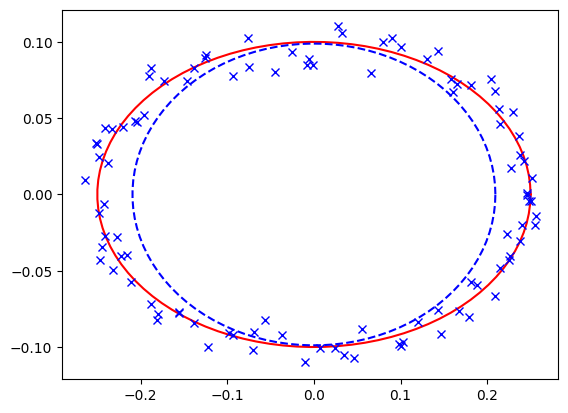

In [66]:
import math
import numpy as np
import scipy.optimize as opt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# ellipse area and circumference
def ellipse_area(a, b):
    """Returns the area of an ellipse parametrized as (x/a)^2 + (y/b)^2 = 1."""
    return math.pi * a * b

def ellipse_circum(a, b):
    """Returns the approximate circumference of an ellipse."""
    return 3.0 * math.pi * (a + b) - math.pi * math.sqrt((3.0 * a + b) * (a + 3.0 * b))

# ellipse plotting
def plot_ellipse(a, b, style='--'):
    """Plot an ellipse parametrized by (a, b)."""
    t = 2.0 * math.pi * torch.linspace(0.0, 1.0, 100)
    plt.plot(a * torch.cos(t), b * torch.sin(t), style)

# ellipse fitting
def fit_ellipse(xs):
    """Find ellipse parameters u = (1/a^2, 1/b^2) that best fit the data."""
    n_batches = xs.size(0)
    results = torch.zeros(n_batches, 2, dtype=torch.double)
    for batch_number, x in enumerate(xs):
        data = x.detach().numpy()
        A = data.T ** 2
        b = np.ones(A.shape[0])
        u0 = np.linalg.lstsq(A, b)[0]
        eq_const = {'type': 'eq',
                    'fun' : lambda u: np.array([1]) if (np.any(u < 0.0)) else np.array([3.0 * math.pi * (math.sqrt(u[0]) + math.sqrt(u[1])) - 
                            math.pi * math.sqrt((3.0 * math.sqrt(u[0]) + math.sqrt(u[1])) * (math.sqrt(u[0]) + 3.0 * math.sqrt(u[1]))) - math.sqrt(u[0] * u[1])])}
        res = opt.minimize(lambda u: np.sum((A @ u - b) ** 2), u0, method='SLSQP', constraints=[eq_const], 
                        options={'ftol': 1e-9, 'disp': False})
        results[batch_number] = torch.tensor(res.x, dtype=torch.double, requires_grad=True)
    return results

# sample a noisy ellipse
m = 100
a, b = 0.25, 0.1
nu = 1.0e-2

print("Ellipse ({:0.3}, {:0.3}) has area {:0.3} and circumference {:0.3}.".format(a, b, ellipse_area(a, b), ellipse_circum(a, b)))

t = 2.0 * math.pi * torch.linspace(0.0, 1.0, m, dtype=torch.double)
data = torch.stack((a * torch.cos(t), b * torch.sin(t)), dim=0)
data = data + nu * torch.randn(2, m, dtype=torch.double)
data = data.unsqueeze(0)

plt.figure()
plot_ellipse(a, b, 'r')
plt.plot(data[0,0], data[0,1], 'bx')

u = fit_ellipse(data).squeeze()
a_hat = math.sqrt(1.0 / u[0])
b_hat = math.sqrt(1.0 / u[1])
plot_ellipse(a_hat, b_hat, 'b--')

print("Ellipse estimate ({:0.3}, {:0.3}) has area {:0.3} and circumference {:0.3}.".format(a_hat, b_hat, ellipse_area(a_hat, b_hat), ellipse_circum(a_hat, b_hat)))

plt.show()

# Derivatives

Computing gradients by hand is tedious so we'll rely on autograd. Here we make use of the infrastructure provided in `ddn.basic.node` from the DDN respoitory (https://github.com/anucvml/ddn). **Requires `ddn` to be installed.**


In [67]:
# set correct location for DDN repository code and import basic node functionality
import sys
sys.path.append("../../../ddn/")
from ddn.pytorch.node import *
    
class EllipseConstrainedProjectionNode(EqConstDeclarativeNode):
    """A DDN node for the constrained ellipse projection problem. Gradients will be calculated automatically."""

    def __init__(self, m):
        super().__init__(eps=1.0e-4) # relax tolerance on optimality test 
        # make sure node is properly constructed
        self.n = tuple([2 * m])
        self.m = m

    def objective(self, xs, y):
        n_batches = xs.size(0)
        data = xs.view(n_batches, 2, -1)  # reshape to (n_batches, 2, ...)
        A = torch.transpose(data, 1, 2).pow(2)  # A has shape [batch_size, N, 2]
        b_tensor = torch.ones(n_batches, A.size(1), 1, device=xs.device, dtype=torch.double)  # [batch_size, N, 1]
        y = y.view(n_batches,2,1)
        return torch.sum((torch.matmul(A, y) - b_tensor).pow(2), dim=(1, 2))
    
    def equality_constraints(self, xs, y):
        sqrt_y = torch.sqrt(y)
        term1 = 3.0 * math.pi * torch.sum(sqrt_y, dim=1)
        term2 = math.pi * torch.sqrt((3.0 * sqrt_y[:, 0] + sqrt_y[:, 1]) * (sqrt_y[:, 0] + 3.0 * sqrt_y[:, 1]))
        term3 = torch.sqrt(y[:, 0] * y[:, 1])
        return term1 - term2 - term3
    
    def solve(self, xs):
        # process batches independently
        n_batches = xs.size(0)
        results = torch.zeros(n_batches, 2, dtype=torch.double)
        for batch_number, x in enumerate(xs):
            assert(len(x) == self.n[0])
            data = x.reshape(2, -1).detach().numpy()
            A = data.T ** 2
            b = np.ones(A.shape[0])

            # compute unconstrained solution as an initialization
            u0 = np.linalg.lstsq(A, b)[0]
            
            # now enforce constraints
            eq_const = {'type': 'eq',
                        'fun' : lambda u: np.array([1]) if (np.any(u < 0.0)) else np.array([3.0 * math.pi * (math.sqrt(u[0]) + math.sqrt(u[1])) - 
                                math.pi * math.sqrt((3.0 * math.sqrt(u[0]) + math.sqrt(u[1])) * (math.sqrt(u[0]) + 3.0 * math.sqrt(u[1]))) - math.sqrt(u[0] * u[1])])}
            #eq_const = {'type': 'eq',
            #            'fun' : lambda u: np.array([ellipse_circum(1.0 / math.sqrt(u[0]), 1.0 / math.sqrt(u[1])) - 1.0])}
            res = opt.minimize(lambda u: np.sum((A @ u - b) ** 2), u0, method='SLSQP', constraints=[eq_const], 
                            options={'ftol': 1e-9, 'disp': False})
            
            results[batch_number] = torch.tensor(res.x, dtype=torch.double, requires_grad=True)
        return results, None
    
    
class EllipseInverseAreaNode(AbstractNode):
    """DDN node for computing one over the area of an ellipse."""
    def __init__(self):
        super().__init__()
        self.n = m

    def solve(self, xs):
        return torch.sqrt(xs[:,0] * xs[:,1]), None

    def gradient(self, xs, y=None, ctx=None):
        z = 2.0 * torch.sqrt(xs[:, 0] * xs[:, 1])
        gradients = torch.stack((xs[:, 1] / z, xs[:, 0] / z), dim=1)
        return tuple(gradients)
    

class ComposedNode(AbstractNode):
    """Composes two deep declarative nodes f and g to produce y = g(f(x)). The resulting composition
    behaves exactly like a single deep declarative node, that is, it has the same interface and
    as such can be further composed with other nodes to form a chain."""

    def __init__(self, nodeA, nodeB):
        assert (nodeA.m == nodeB.n)
        super().__init__()
        self.nodeA = nodeA
        self.nodeB = nodeB

    def solve(self, x):
        """Overrides the solve method to first compute z = nodeA.solve(x) and then y = nodeB.solve(z). Returns
        the dual variables from both nodes."""
        z, ctxA = self.nodeA.solve(x)
        y, ctxB = self.nodeB.solve(z)
        return y, {'ctxA': ctxA, 'ctxB': ctxB, 'z': z}

    def gradient(self, x, y=None, ctx=None):
        """Overrides the gradient method to compute the composed gradient by the chain rule."""

        # we need to resolve for z since there is currently no way to store this
        if ctx is None:
            z, _ = self.nodeA.solve(x)
        else:
            z = ctx['z']
        Dz = self.nodeA.jacobian(x, y=z)
        Dz = torch.stack(Dz).squeeze(0)
        # print("Dz.shape, Dz", Dz.shape, Dz, "type", type(Dz), "len", len(Dz))
        Dy = self.nodeB.gradient(z)
        Dy = torch.stack(Dy)
        Dy = Dy.view(Dy.size(0),1,-1)
        # print("Dy.shape, Dy", Dy.shape, Dy, "type", type(Dy), "len", len(Dy))
        # print("result", torch.bmm(Dy, Dz))
        return torch.bmm(Dy, Dz)

# Optimizing

We now optimize the inital samples in a direction to maximize the area of the projected ellipse using gradient descent.

    0: ellipse estimate (0.209, 0.0989) has area 0.0651 and circumference 1.0.
    1: ellipse estimate (0.179, 0.138) has area 0.0776 and circumference 1.0.
    2: ellipse estimate (0.173, 0.144) has area 0.0786 and circumference 1.0.
    3: ellipse estimate (0.169, 0.149) has area 0.0791 and circumference 1.0.
    4: ellipse estimate (0.167, 0.152) has area 0.0793 and circumference 1.0.
    5: ellipse estimate (0.165, 0.154) has area 0.0794 and circumference 1.0.
    6: ellipse estimate (0.163, 0.155) has area 0.0795 and circumference 1.0.
    7: ellipse estimate (0.162, 0.156) has area 0.0795 and circumference 1.0.
    8: ellipse estimate (0.161, 0.157) has area 0.0796 and circumference 1.0.
    9: ellipse estimate (0.161, 0.158) has area 0.0796 and circumference 1.0.
Final ellipse (0.16, 0.158) has area 0.0796 and circumference 1.0.


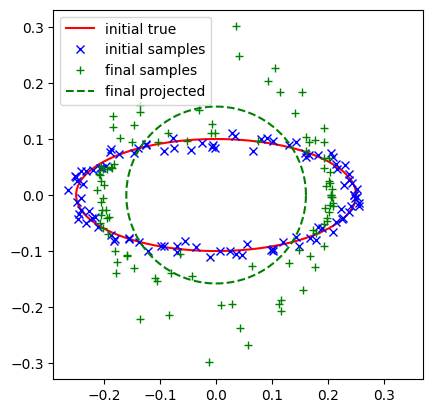

In [72]:
from ddn.pytorch.composition import ComposedNode
from copy import deepcopy

node = ComposedNode(EllipseConstrainedProjectionNode(m), EllipseInverseAreaNode())

n_batches = data.size(0)
x_init = data.view(n_batches, -1)
x_init.requires_grad = True
y_init, _ = node.solve(x_init)

history = [y_init]

x = x_init.clone()
for i in range(10):
    y, _ = node.solve(x)

    history.append(y)

    if True:
        u = fit_ellipse(x.view(n_batches, 2, -1))
        a_hat = math.sqrt(1.0 / u[:,0])
        b_hat = math.sqrt(1.0 / u[:,1])
        print("{:5d}: ellipse estimate ({:0.3}, {:0.3}) has area {:0.3} and circumference {:0.3}.".format(i, a_hat, b_hat, ellipse_area(a_hat, b_hat), ellipse_circum(a_hat, b_hat)))
    ctx = {'z': u}
    dLdx = node.gradient(x, y, ctx=ctx)
    x -= 1.0e-2 * dLdx.flatten()
    
# plot results
plt.figure()
#plt.semilogy(history, lw=2)

plot_ellipse(a, b, 'r')
plt.plot(data[0,0], data[0,1], 'bx')

final_data = x.reshape(1, 2, -1).detach()
plt.plot(final_data[0,0], final_data[0,1], 'g+')

u = fit_ellipse(final_data)
a_hat = math.sqrt(1.0 / u[:,0])
b_hat = math.sqrt(1.0 / u[:,1])
plot_ellipse(a_hat, b_hat, 'g--')

print("Final ellipse ({:0.3}, {:0.3}) has area {:0.3} and circumference {:0.3}.".format(a_hat, b_hat, ellipse_area(a_hat, b_hat), ellipse_circum(a_hat, b_hat)))
plt.axis('square')
plt.legend(['initial true', 'initial samples', 'final samples', 'final projected'])
plt.show()

    0: ellipse estimate (0.209, 0.0989) has area 0.0651 and circumference 1.0.
    1: ellipse estimate (0.179, 0.138) has area 0.0776 and circumference 1.0.
    2: ellipse estimate (0.173, 0.144) has area 0.0786 and circumference 1.0.
    3: ellipse estimate (0.169, 0.149) has area 0.0791 and circumference 1.0.
    4: ellipse estimate (0.167, 0.152) has area 0.0793 and circumference 1.0.
    5: ellipse estimate (0.165, 0.154) has area 0.0794 and circumference 1.0.
    6: ellipse estimate (0.163, 0.155) has area 0.0795 and circumference 1.0.
    7: ellipse estimate (0.162, 0.156) has area 0.0795 and circumference 1.0.
    8: ellipse estimate (0.161, 0.157) has area 0.0796 and circumference 1.0.
    9: ellipse estimate (0.161, 0.158) has area 0.0796 and circumference 1.0.
Final ellipse (0.16, 0.158) has area 0.0796 and circumference 1.0.


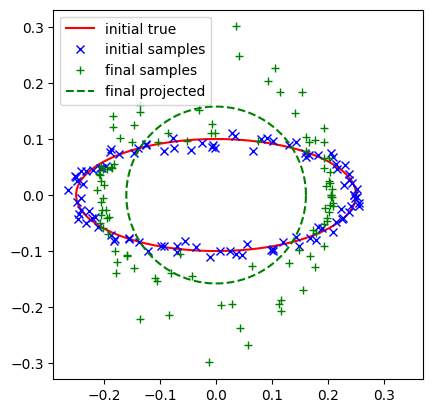

In [74]:
node = EllipseConstrainedProjectionNode(m)

class EllipseConstrainedProjectionFunction(DeclarativeFunction):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

class SqrtProductLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return torch.sqrt(input[:,0] * input[:, 1])

y_init = EllipseConstrainedProjectionFunction.apply(node, x_init)
sqrt_prod_loss = SqrtProductLoss()
history = [y_init]
x = x_init.clone().detach().requires_grad_(True)
torch_opt = torch.optim.SGD([x], lr=0.01)

for i in range(10):
    torch_opt.zero_grad(set_to_none=True)
    y = EllipseConstrainedProjectionFunction.apply(node, x)
    history.append(y.detach().clone())
    if True:
        u = fit_ellipse(x.view(n_batches, 2, -1))
        a_hat = math.sqrt(1.0 / u[:,0])
        b_hat = math.sqrt(1.0 / u[:,1])
        print("{:5d}: ellipse estimate ({:0.3}, {:0.3}) has area {:0.3} and circumference {:0.3}.".format(i, a_hat, b_hat, ellipse_area(a_hat, b_hat), ellipse_circum(a_hat, b_hat)))
    loss = sqrt_prod_loss(y)
    loss.backward()
    torch_opt.step()

# plot results
plt.figure()
#plt.semilogy(history, lw=2)

plot_ellipse(a, b, 'r')
plt.plot(data[0,0], data[0,1], 'bx')

final_data = x.reshape(1, 2, -1).detach()
plt.plot(final_data[0,0], final_data[0,1], 'g+')

u = fit_ellipse(final_data)
a_hat = math.sqrt(1.0 / u[:,0])
b_hat = math.sqrt(1.0 / u[:,1])
plot_ellipse(a_hat, b_hat, 'g--')

print("Final ellipse ({:0.3}, {:0.3}) has area {:0.3} and circumference {:0.3}.".format(a_hat, b_hat, ellipse_area(a_hat, b_hat), ellipse_circum(a_hat, b_hat)))
plt.axis('square')
plt.legend(['initial true', 'initial samples', 'final samples', 'final projected'])
plt.show()